In [1]:
!pip install tld colorama scikit-learn xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 3.2 MB/s eta 0:00:00


<a id="1"></a> <br>
# 📥 Importing Libraries

In [2]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from tld import get_tld, is_tld

<a id="2"></a> <br>
# 🗃️ Load Dataset

In [5]:
from google.colab import files
uploaded = files.upload()

Saving malicious_phish_pangkas.csv to malicious_phish_pangkas.csv


In [6]:
data = pd.read_csv('/content/malicious_phish_pangkas.csv')
data.head()

,url,type
0,funtaipeibackpackers.hostel.com/,benign
1,http://distractify.com/post/related/id/55526ac...,benign
2,associatedcontent.com/article/1270442/2008_big...,benign
3,http://mail.inifapcirpac.gob.mx/Desarrollo/Sig...,phishing
4,http://www.metalsul.ind.br/site/index.php?opti...,defacement


<a id="3"></a> <br>
# 📝 Meta information of Dataframe

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     5000 non-null   object
 1   type    5000 non-null   object
dtypes: object(2)
memory usage: 78.2+ KB


<a id="4"></a>
# 🔎 Checking for NaN values

In [8]:
data.isnull().sum()

url     0
type    0
dtype: int64

In [9]:
count = data.type.value_counts()
count

benign        3558
defacement     825
phishing       366
malware        251
Name: type, dtype: int64

<ipython-input-10-2e1e533982a0>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax= sns.barplot(x=count.index, y=count, palette=colors)


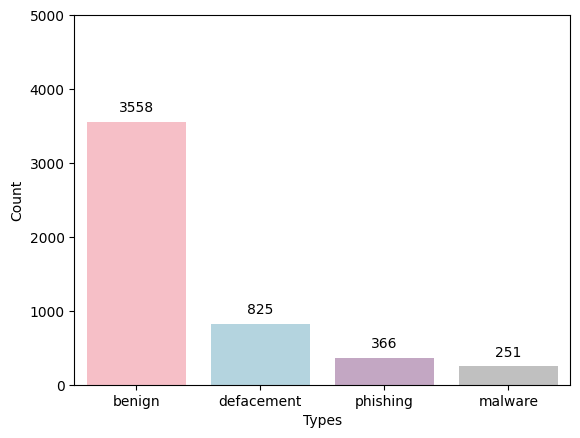

In [10]:
colors = [(255, 182, 193), (173, 216, 230), (200, 162, 200), (192, 192, 192)]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]
ax= sns.barplot(x=count.index, y=count, palette=colors)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.xlabel('Types')
plt.ylim(0, 5000)
plt.ylabel('Count');

<h4>first have to omit the (www.) from the URL which is in fact a sub domain in itself.</h4>

In [11]:
data['url'] = data['url'].replace('www.', '', regex=True)
data

,url,type
0,funtaipeibackpackers.hostel.com/,benign
1,http://distractify.com/post/related/id/55526ac...,benign
2,associatedcontent.com/article/1270442/2008_big...,benign
3,http://mail.inifapcirpac.gob.mx/Desarrollo/Sig...,phishing
4,http://metalsul.ind.br/site/index.php?option=c...,defacement
...,...,...
4995,azlyrics.com/lyrics/aliceinchains/angrychair.html,benign
4996,letrs.indiana.edu/cgi/t/text/text-idx?c=wright...,benign
4997,encyclopedia.com/topic/Jacques_Yves_Cousteau.aspx,benign
4998,wikinvest.com/stock/MTY_Food_Group_(TSE:MTY),benign


In [12]:
data.head()

,url,type
0,funtaipeibackpackers.hostel.com/,benign
1,http://distractify.com/post/related/id/55526ac...,benign
2,associatedcontent.com/article/1270442/2008_big...,benign
3,http://mail.inifapcirpac.gob.mx/Desarrollo/Sig...,phishing
4,http://metalsul.ind.br/site/index.php?option=c...,defacement


In [13]:
rem = {"Category": {"benign": 0, "defacement": 1, "phishing":2, "malware":3}}
data['Category'] = data['type']
data = data.replace(rem)

<a id="5"></a> <br>
# 🦾 Feature Extraction

In [14]:
data['url_len'] = data['url'].apply(lambda x: len(str(x)))

In [15]:
def process_tld(url):
    try:
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        pri_domain= res.parsed_url.netloc
    except :
        pri_domain= None
    return pri_domain

In [16]:
data['domain'] = data['url'].apply(lambda i: process_tld(i))

In [17]:
data.head()

,url,type,Category,url_len,domain
0,funtaipeibackpackers.hostel.com/,benign,0,32,funtaipeibackpackers.hostel.com
1,http://distractify.com/post/related/id/55526ac...,benign,0,87,distractify.com
2,associatedcontent.com/article/1270442/2008_big...,benign,0,84,associatedcontent.com
3,http://mail.inifapcirpac.gob.mx/Desarrollo/Sig...,phishing,2,62,mail.inifapcirpac.gob.mx
4,http://metalsul.ind.br/site/index.php?option=c...,defacement,1,104,metalsul.ind.br


In [18]:
feature = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
for a in feature:
    data[a] = data['url'].apply(lambda i: i.count(a))

In [19]:
data.head()

,url,type,Category,url_len,domain,@,?,-,=,.,#,%,+,$,!,*,",",//
0,funtaipeibackpackers.hostel.com/,benign,0,32,funtaipeibackpackers.hostel.com,0,0,0,0,2,0,0,0,0,0,0,0,0
1,http://distractify.com/post/related/id/55526ac...,benign,0,87,distractify.com,0,0,0,0,1,0,0,0,0,0,0,0,1
2,associatedcontent.com/article/1270442/2008_big...,benign,0,84,associatedcontent.com,0,0,0,0,2,0,0,0,0,0,0,0,0
3,http://mail.inifapcirpac.gob.mx/Desarrollo/Sig...,phishing,2,62,mail.inifapcirpac.gob.mx,0,0,1,0,4,0,0,0,0,0,0,0,1
4,http://metalsul.ind.br/site/index.php?option=c...,defacement,1,104,metalsul.ind.br,0,1,1,4,3,0,0,0,0,0,0,0,1


In [20]:
def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

In [21]:
data['abnormal_url'] = data['url'].apply(lambda i: abnormal_url(i))

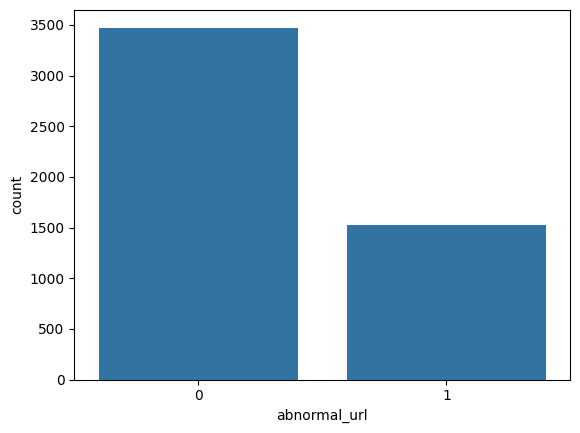

In [22]:
sns.countplot(x='abnormal_url', data=data);

In [23]:
def httpSecure(url):
    htp = urlparse(url).scheme
    match = str(htp)
    if match=='https':
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

In [24]:
data['https'] = data['url'].apply(lambda i: httpSecure(i))

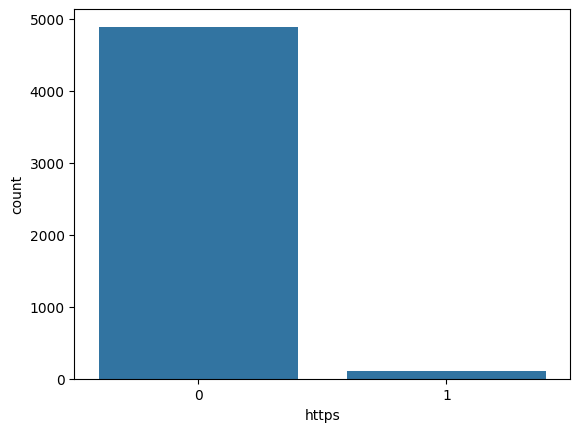

In [25]:
sns.countplot(x='https', data=data);

<h4>Counts the number of digit characters in a URL</h4>

In [26]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

In [27]:
data['digits']= data['url'].apply(lambda i: digit_count(i))

<h4>Counts the number of letter characters in a URL</h4>

In [28]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

In [29]:
data['letters']= data['url'].apply(lambda i: letter_count(i))

<h4>Checks to see whether URL contains a shortening service</h4>

In [30]:
def Shortining_Service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

In [31]:
data['Shortining_Service'] = data['url'].apply(lambda x: Shortining_Service(x))

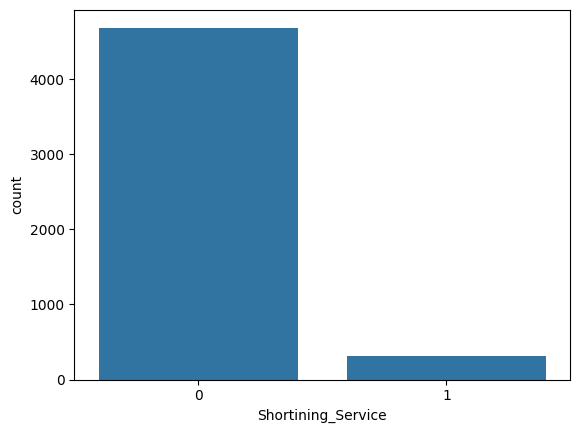

In [32]:
sns.countplot(x='Shortining_Service', data=data);

In [33]:
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
    if match:
        return 1
    else:
        return 0

In [34]:
data['having_ip_address'] = data['url'].apply(lambda i: having_ip_address(i))

In [35]:
data['having_ip_address'].value_counts()

0    4893
1     107
Name: having_ip_address, dtype: int64

<ipython-input-36-d14f9601ff3f>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), linewidths=.5)


<Axes: >

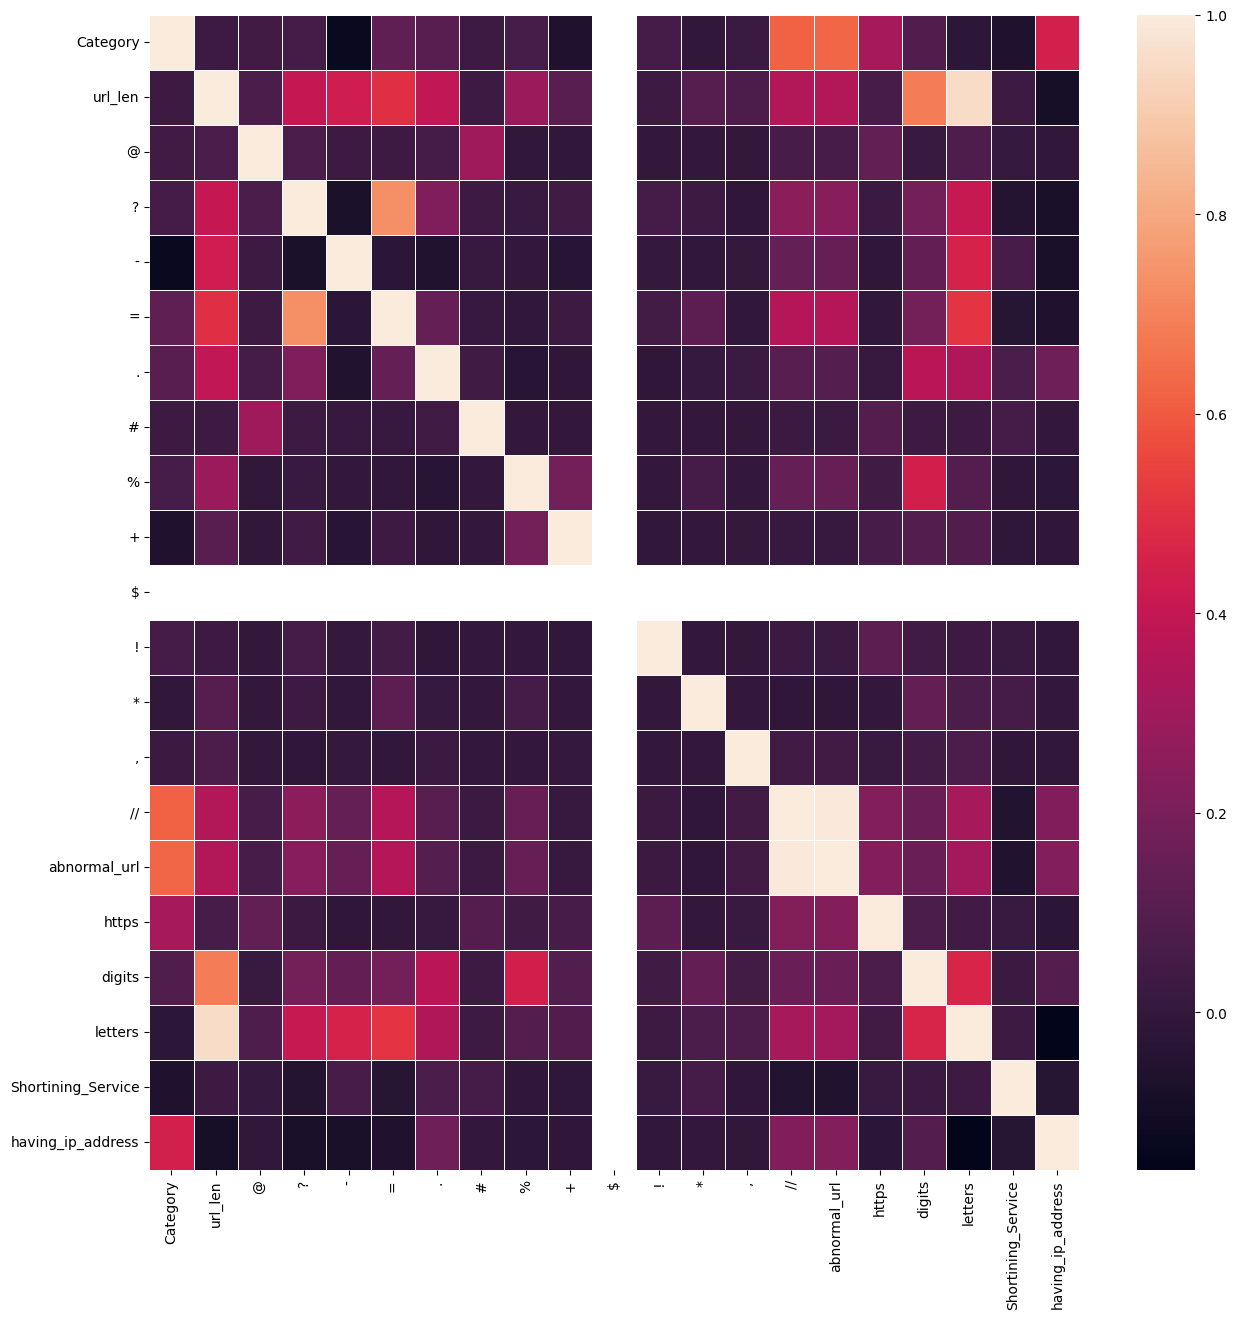

In [36]:
plt.figure(figsize=(15, 15))
sns.heatmap(data.corr(), linewidths=.5)

In [37]:
X = data.drop(['url','type','Category','domain'],axis=1)#,'type_code'
y = data['Category']

<a id="6"></a> <br>
# ✂️ Train & Test Split

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)


<a id="7"></a> <br>
# <img src="https://cdn-icons-png.flaticon.com/32/4149/4149680.png"/> Training models

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Assuming X and y are your dataset's features and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost and RandomForest models
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Dictionary to store only the models you want to evaluate
base_models = {
    'Random Forest': rf,
    'XGBoost': xgb
}

# Dictionary to store individual accuracies
individual_accuracies = {}

# Train each model individually, then evaluate their accuracies
for name, model in base_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred) * 100  # Convert to percentage
    individual_accuracies[name] = accuracy
    print(f'{name} - Test Accuracy: {accuracy:.2f}%')  # Print as percentage

# Display all accuracies together for comparison
print("\nSummary of Accuracies:")
for model, acc in individual_accuracies.items():
    print(f'{model}: {acc:.2f}%')


Random Forest - Test Accuracy: 93.60%
XGBoost - Test Accuracy: 93.40%

Summary of Accuracies:
Random Forest: 93.60%
XGBoost: 93.40%


<a id="8"></a> <br>
# <img src="https://cdn-icons-png.flaticon.com/64/3094/3094836.png"/> Final Report

In [40]:
output = pd.DataFrame({"Model": list(individual_accuracies.keys()),
                       "Accuracy": list(individual_accuracies.values())})

In [41]:
output

,Model,Accuracy
0,Random Forest,93.6
1,XGBoost,93.4


<ipython-input-42-5f0698c001da>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plots = sns.barplot(x='Model', y='Accuracy', data=output, palette=custom_colors)


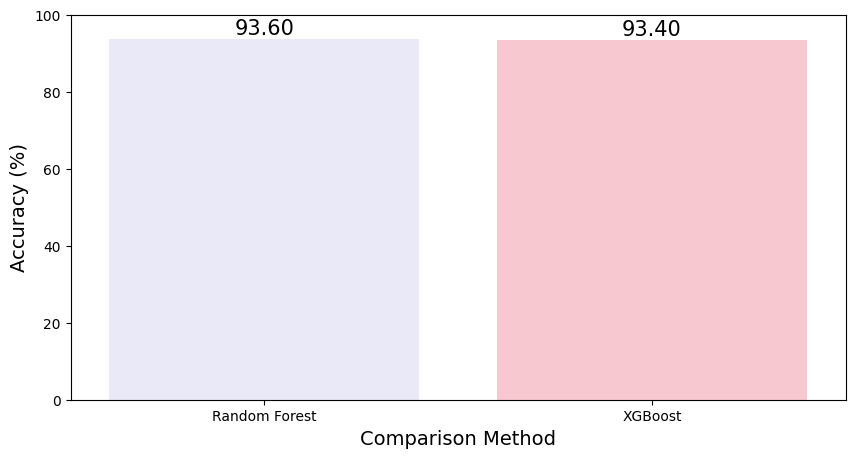

In [42]:
plt.figure(figsize=(10, 5))
custom_colors = ['lavender', 'pink']
plots = sns.barplot(x='Model', y='Accuracy', data=output, palette=custom_colors)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')
plt.xlabel("Comparison Method", size=14)
plt.ylim(0, 100)
plt.ylabel("Accuracy (%)", size=14)
plt.show()

<a id="9"></a> <br>
# ✨ Thanks